<a href="https://colab.research.google.com/github/Reyad02/PoultryScan/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train=True):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return test_loader, len(test_data)


In [ ]:
dataset_path = "/content/drive/MyDrive/DIP/DIP_Splited_Aug_Dataset"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
test_loader, test_data_len = get_data_loaders(dataset_path, 32, train=False)

classes = get_classes("/content/drive/MyDrive/DIP/DIP_Splited_Aug_Dataset/train")
print(classes, len(classes))


['cocci', 'healthy', 'ncd', 'salmo'] 4


In [ ]:
dataloaders = {
    "train": train_loader
}

dataset_sizes = {
    "train": train_data_len
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests


In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier for ViT model
n_inputs = model.classifier.in_features  # Accessing the in_features of the last layer in classifier
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)


model = model.to(device)
print(model.classifier)


Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

# Optimizer
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)

            if phase == 'train' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'train_acc': train_accs
    }

    return model, history

#model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


In [ ]:
model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()


Epoch 0/9
----------


100%|██████████| 50/50 [06:43<00:00,  8.07s/it]


train Loss: 0.5515 Acc: 0.9172
Epoch 1/9
----------


100%|██████████| 50/50 [06:24<00:00,  7.70s/it]


train Loss: 0.4364 Acc: 0.9765
Epoch 2/9
----------


100%|██████████| 50/50 [06:27<00:00,  7.75s/it]


train Loss: 0.4200 Acc: 0.9820
Epoch 3/9
----------


100%|██████████| 50/50 [06:52<00:00,  8.24s/it]


train Loss: 0.4092 Acc: 0.9882
Epoch 4/9
----------


100%|██████████| 50/50 [06:29<00:00,  7.79s/it]


train Loss: 0.4043 Acc: 0.9893
Epoch 5/9
----------


100%|██████████| 50/50 [06:28<00:00,  7.78s/it]


train Loss: 0.3972 Acc: 0.9920
Epoch 6/9
----------


100%|██████████| 50/50 [06:26<00:00,  7.73s/it]


train Loss: 0.3944 Acc: 0.9932
Epoch 7/9
----------


100%|██████████| 50/50 [06:32<00:00,  7.85s/it]


train Loss: 0.3912 Acc: 0.9943
Epoch 8/9
----------


100%|██████████| 50/50 [06:40<00:00,  8.01s/it]


train Loss: 0.3912 Acc: 0.9940
Epoch 9/9
----------


100%|██████████| 50/50 [06:50<00:00,  8.20s/it]


train Loss: 0.3848 Acc: 0.9946
Best val Acc: 0.994646


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

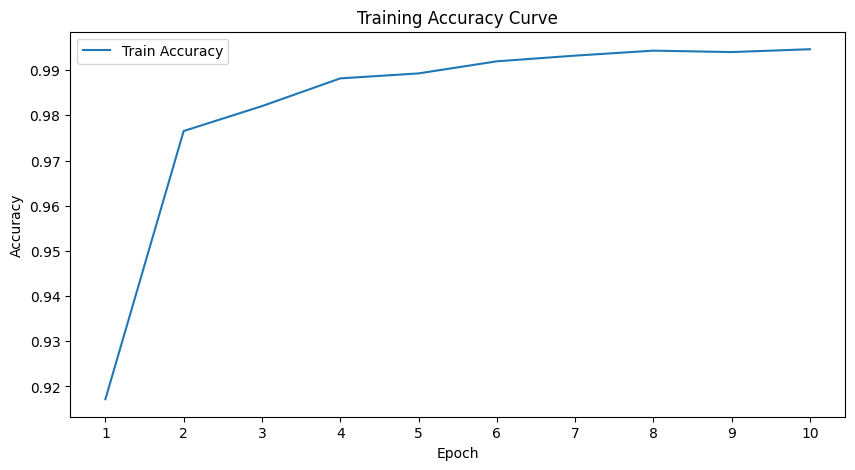

In [ ]:
num_epochs = 10
# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in history['train_acc']], label='Train Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()


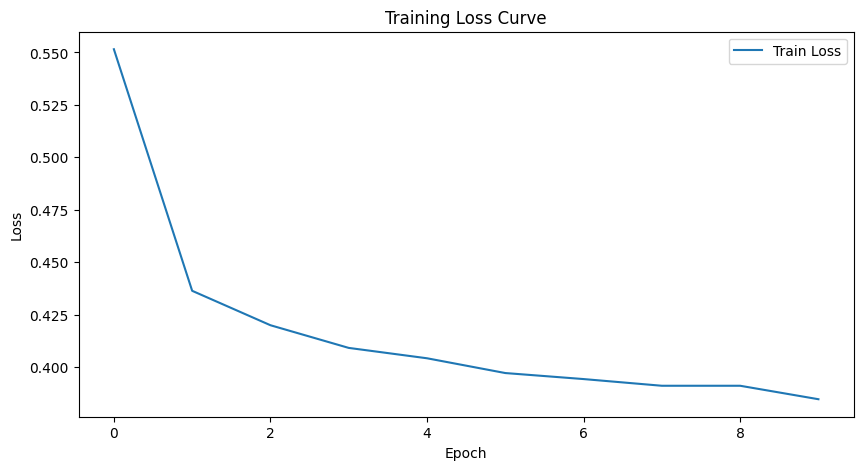

In [ ]:

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history['train_loss'], label='Train Loss')
plt.legend()
plt.show()

In [ ]:
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output.logits, target)  # Use logits to compute the loss
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output.logits, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
    100 * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)
))


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]

Test Loss: 0.3934
Test Accuracy of cocci: 99% (418/420)
Test Accuracy of healthy: 98% (397/405)
Test Accuracy of   ncd: 99% (297/298)
Test Accuracy of salmo: 99% (444/445)
Test Accuracy of 99% (1556/1568)


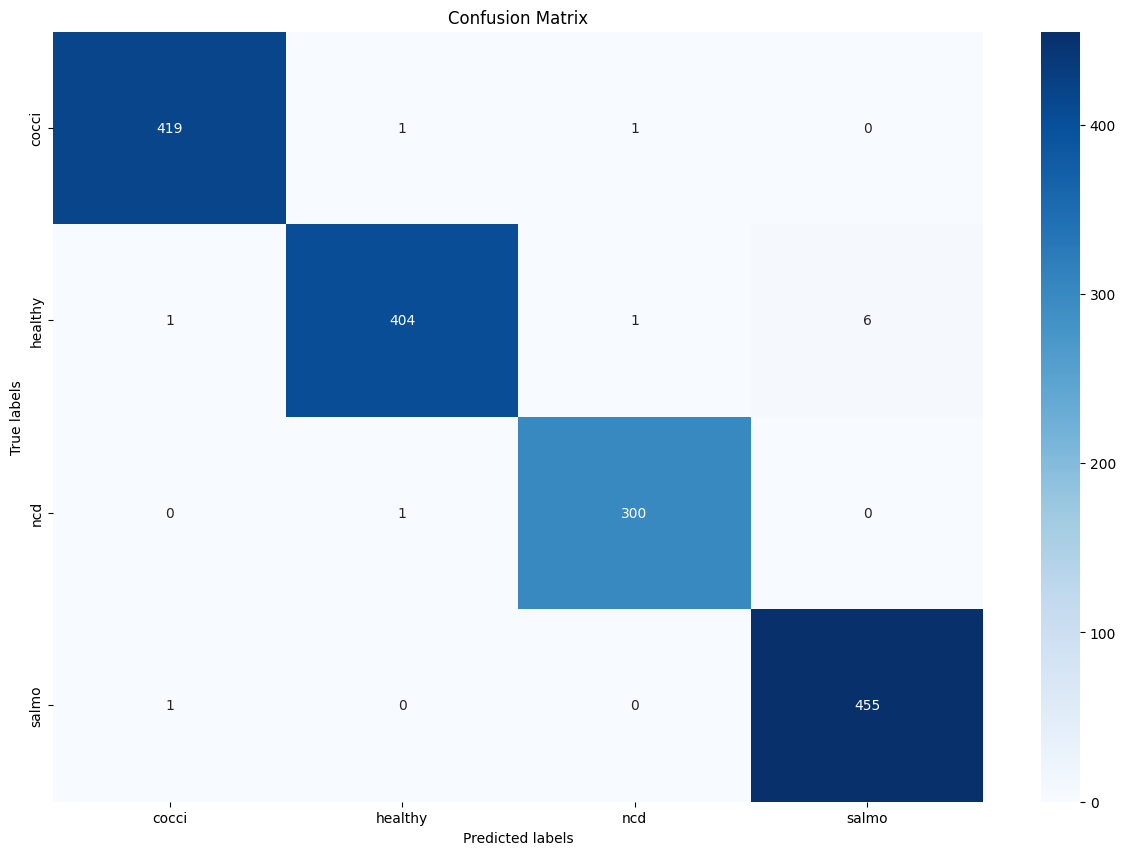

Classification Report:
              precision    recall  f1-score   support

       cocci       1.00      1.00      1.00       421
     healthy       1.00      0.98      0.99       412
         ncd       0.99      1.00      1.00       301
       salmo       0.99      1.00      0.99       456

    accuracy                           0.99      1590
   macro avg       0.99      0.99      0.99      1590
weighted avg       0.99      0.99      0.99      1590

Class: cocci
  Precision: 0.9952
  Recall:    0.9952
  F1 Score:  0.9952
--------------------
Class: healthy
  Precision: 0.9951
  Recall:    0.9806
  F1 Score:  0.9878
--------------------
Class: ncd
  Precision: 0.9934
  Recall:    0.9967
  F1 Score:  0.9950
--------------------
Class: salmo
  Precision: 0.9870
  Recall:    0.9978
  F1 Score:  0.9924
--------------------
Overall Metrics:
  Overall Precision: 0.9925
  Overall Recall:    0.9925
  Overall F1 Score:  0.9924


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)  # Extract logits and apply torch.max()

    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_names = classes  # Your list of class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

for i, cls in enumerate(class_names):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")
    print("-" * 20)

# Compute overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Overall Metrics:")
print(f"  Overall Precision: {overall_precision:.4f}")
print(f"  Overall Recall:    {overall_recall:.4f}")
print(f"  Overall F1 Score:  {overall_f1:.4f}")
